In [ ]:
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Initially used numpy for reading csv but it gave error at line 38 because there was a comma. So i guess it is not for reading text. therefore used pandas.

In [108]:
# train data
tdf = pd.read_csv("CompleteDataset.csv", sep="|")
# test data
#vdf = pd.read_csv('defects.csv')
vdf = vdf.sample(frac = 1, random_state=2).reset_index()
#print(tdf.head)
#Shuffling and splitting the dataset into 70% training and 30% testing
tdf, vdf = train_test_split(tdf, test_size=0.3, random_state=42, shuffle=True)

#tdf = vdf.iloc[:700]
#vdf = vdf.iloc[700:]



print(vdf.head)
print(tdf.head)

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2


<bound method NDFrame.head of                                                  summary             category  \
24638  Customer Management system failed to log custo...        Logging Error   
9134   Inventory Management System: New inventory ret...       Resource Error   
26463  Product catalogue system does not meet specifi...  Specification Error   
9477   Resource Catalog UI: Misconfigured user interf...  Configuration Error   
5954   Patching process of the Order Cancellation mod...       Patching Error   
...                                                  ...                  ...   
30175  The application logs fail to capture specific ...        Logging Error   
16093  Logging system misconfigured for the hybrid cl...        Logging Error   
31952  The client and server are using different vers...  Communication Error   
28027  Use of deprecated version of Analysis module l...        Version Error   
9112   TMF-630 Issue: The system does not support att...       Resource Error  

Get number of samples and words per sample to compare. Then using https://developers.google.com/machine-learning/guides/text-classification/step-2-5 decide to the model.

In [ ]:
rows = len(df)
total_words = df['summary'].apply(lambda x: len(str(x).split())).sum()
w_per_s = total_words / rows
w_per_s

10.276476471207495

Since it is less than 1500 we are going with MLP.

In [54]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Berfore we fed model with data. We should tokenize. Then train with it.

In [111]:
# Define train_texts, train_labels, val_texts, and val_labels earlier
train_texts = tdf['summary']
train_labels = tdf['super']
val_texts = vdf['summary']
val_labels = vdf['super']
# Initialize a label encoder
label_encoder = LabelEncoder()

# Vectorize the texts using the function
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
# Fit the encoder on the training labels and transform both train and validation labels
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


MLP:

Training Score (Accuracy): 0.9999248092033535
0.9309649122807018


ValueError: ignored

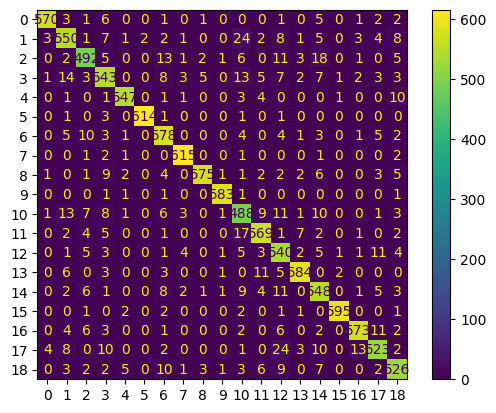

In [112]:

# Initialize the MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, activation='relu', solver='adam', random_state=42)

# Train the model
mlp_clf.fit(x_train, y_train_encoded)

# Predict on the validation set
y_val_pred_mlp = mlp_clf.predict(x_val)

# Calculate the accuracy
training_score = mlp_clf.score(x_train, y_train_encoded)
print("Training Score (Accuracy):", training_score)


accuracy_mlp = accuracy_score(y_val_encoded, y_val_pred_mlp, normalize=True)
print(accuracy_mlp)
cm = confusion_matrix(y_val_encoded, y_val_pred_mlp)
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig.plot()
plt.show()

print(classification_report(y_val_encoded, y_val_pred_mlp))

SVM:

In [113]:
# Training the SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(x_train, y_train_encoded)
y_val_pred_svm = svm.predict(x_val)
# Calculating accuracy and classification report for the SVM model
accuracy_svm_test = accuracy_score(y_val_encoded, y_val_pred_svm)
classification_rep_svm_test_new = classification_report(y_val_encoded, y_val_pred_svm, target_names=label_encoder.classes_)
print()
print(accuracy_svm_test)
print(classification_rep_svm_test_new)


0.9398245614035088
                       precision    recall  f1-score   support

    Algorithmic Error       0.98      0.98      0.98       593
          Build Error       0.93      0.88      0.91       622
  Communication Error       0.91      0.91      0.91       560
Data Management Error       0.89      0.89      0.89       620
     Deployment Error       0.98      0.98      0.98       569
         Design Error       1.00      0.99      0.99       621
    Integration Error       0.89      0.94      0.91       617
        Logging Error       0.94      1.00      0.97       623
      Migration Error       0.97      0.96      0.96       614
       Patching Error       0.99      1.00      1.00       588
    Performance Error       0.90      0.84      0.87       563
       Resource Error       0.93      0.96      0.94       611
       Security Error       0.89      0.92      0.90       587
  Specification Error       0.98      0.94      0.96       615
         System Error       0.92  

GBDT:

In [114]:
# Initializing and training the GBDT classifier
gbdt_classifier = GradientBoostingClassifier(random_state=42)
gbdt_classifier.fit(x_train, y_train_encoded)

# Predicting on the test set
y_test_pred_gbdt = gbdt_classifier.predict(x_val)

# Calculating accuracy and classification report for the GBDT model
accuracy_gbdt_test = accuracy_score(y_val_encoded, y_test_pred_gbdt)
classification_rep_gbdt_test = classification_report(y_val_encoded, y_test_pred_gbdt)
print()
print(accuracy_gbdt_test)
print(classification_rep_gbdt_test)


0.8839473684210526
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       593
           1       0.89      0.80      0.85       622
           2       0.83      0.78      0.81       560
           3       0.75      0.88      0.81       620
           4       0.97      0.96      0.97       569
           5       0.99      0.99      0.99       621
           6       0.87      0.84      0.86       617
           7       0.94      0.99      0.96       623
           8       0.97      0.94      0.95       614
           9       0.98      1.00      0.99       588
          10       0.62      0.72      0.67       563
          11       0.88      0.89      0.88       611
          12       0.86      0.78      0.82       587
          13       0.96      0.92      0.94       615
          14       0.84      0.86      0.85       602
          15       0.98      0.98      0.98       605
          16       0.91      0.86      0.88       610
       